In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

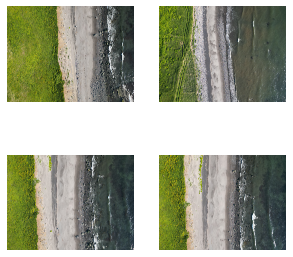

In [2]:
link_4 = '/home/jupyter/datasphere/s3/garbage-data/drone-photo/' +\
         '2023 год лето, Южно-Камчатский заказник, Охотоморское побережье/1 km'
         
def show_label(link, n=2, figsize=(5, 5)):
    ncols = nrows = n
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)

    links = os.listdir(link)
    rand_img_names = np.random.choice(links, size=ncols * nrows, replace=False)
    for i, img_name in enumerate(rand_img_names):
        image_path = os.path.join(link, img_name)
        
        img = Image.open(image_path).convert('RGB')
        img.resize((img.size[0] // 10, img.size[1] // 10))
        img = np.asarray(img)

        axes[i // nrows, i % nrows].imshow(img)
        axes[i // nrows, i % nrows].axis('off')
    plt.show()

show_label(link_4)

In [3]:
SUFFIXES = {'png', 'jpg', 'jpeg', 'JPEG', 'JPG'}

def image_coroutine(link):
    links = sorted([l for l in os.listdir(link) if l.split('.')[-1] in SUFFIXES])
    for i, img_name in enumerate(links):
        image_path = os.path.join(link, img_name)

        img = Image.open(image_path).convert('RGB')
        img = np.asarray(img)
        
        yield img
        
imc = image_coroutine(link_4)

In [4]:
SUFFIXES = {'png', 'jpg', 'jpeg', 'JPEG', 'JPG'}

def crop_coroutine(img, size=256):
    rows, cols, _ = img.shape
    rows, cols = rows // 256, cols // 256

    for row in range(rows):
        for col in range(cols):
            crop = img[size * row: size * (row + 1), size * col: size * (col + 1)]
        
            yield crop
        
cc = crop_coroutine(next(imc))

In [5]:
def dataset_corutine(link, n=np.inf):
    number = 0
    img_cor = image_coroutine(link)
    for img in img_cor:
        crop_cor = crop_coroutine(img)
        for crop in crop_cor:
            number += 1
            yield crop
            if number == n:
                return

dc = dataset_corutine(link_4)

In [6]:
def get_img_hist(img, bins=256):
    r_hist = np.histogram(img[:, :, 0], bins=np.arange(0, 256, 1), density=True)[0]
    g_hist = np.histogram(img[:, :, 1], bins=np.arange(0, 256, 1), density=True)[0]
    b_hist = np.histogram(img[:, :, 2], bins=np.arange(0, 256, 1), density=True)[0]

    return np.concatenate([r_hist, g_hist, b_hist]) / 3

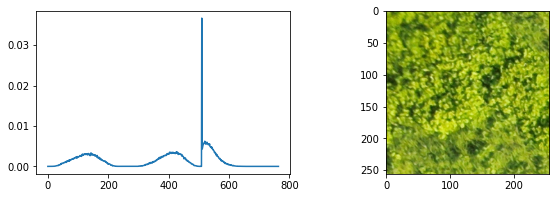

In [7]:
img_ = next(cc)
fig, axes = plt.subplots(ncols=2, figsize=(10, 3))

axes[1].imshow(img_)
axes[0].plot(get_img_hist(img_))

In [8]:
data_cor = dataset_corutine(link_4, 10000)
imgs = []
probs = []
for i, crop in enumerate(data_cor):
    imgs.append(crop)
    probs.append(get_img_hist(crop))

probs = np.array(probs)
imgs = np.concatenate([img[None] for img in imgs], axis=0)

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_probs = pca.fit_transform(probs).T

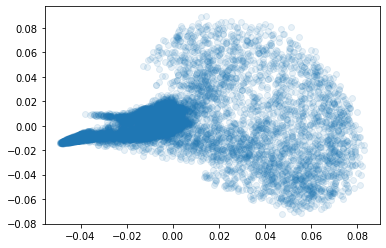

In [10]:
plt.scatter(pca_probs[0], pca_probs[1], alpha=0.1)

In [15]:
import umap.umap_ as umap
reducer = umap.UMAP()

umap_probs = reducer.fit_transform(probs).T

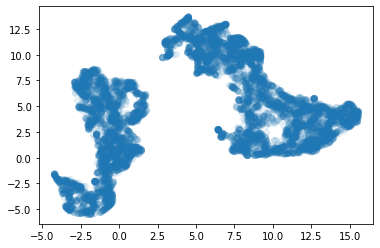

In [17]:
plt.scatter(umap_probs[0], umap_probs[1], alpha=0.1);

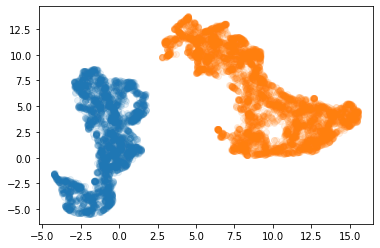

In [19]:
mask = umap_probs[0] < 2.5
plt.scatter(umap_probs[0][mask], umap_probs[1][mask], alpha=0.1);
plt.scatter(umap_probs[0][~mask], umap_probs[1][~mask], alpha=0.1);

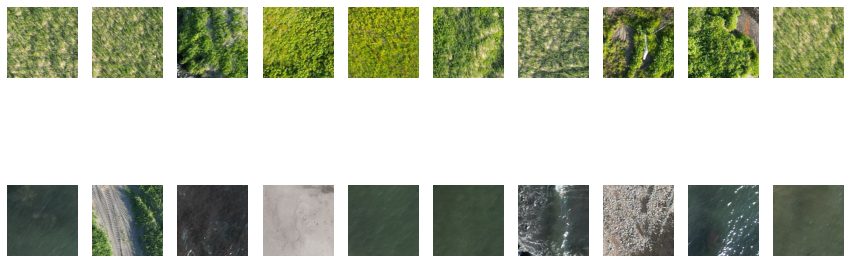

In [28]:
ncols = 10
fig, axes = plt.subplots(ncols=ncols, nrows=2, figsize=(15, 6))

for i, ri in enumerate(np.random.choice(np.arange(imgs[mask].shape[0]), ncols)):
    axes[0, i].imshow(imgs[mask][ri])
    axes[0, i].axis('off')
    
for i, ri in enumerate(np.random.choice(np.arange(imgs[~mask].shape[0]), ncols)):
    axes[1, i].imshow(imgs[~mask][ri])
    axes[1, i].axis('off')

In [31]:
l, r = umap_probs[0].min(), umap_probs[0].max()
d, u = umap_probs[1].min(), umap_probs[1].max()

In [57]:
x_grid = np.linspace(l, r, 80)
y_grid = np.linspace(d, u, 80)

X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

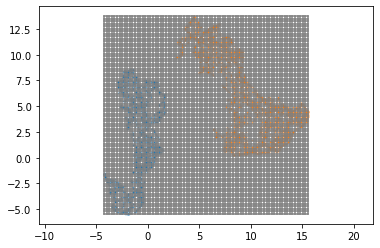

In [58]:
mask = umap_probs[0] < 2.5
plt.scatter(umap_probs[0][mask], umap_probs[1][mask], alpha=0.5, s=0.5);
plt.scatter(umap_probs[0][~mask], umap_probs[1][~mask], alpha=0.5, s=0.5);

for xg in x_grid:
    plt.plot([xg, xg], [d, u], c='grey')
    
for yg in y_grid:
    plt.plot([l, r], [yg, yg], c='grey')

plt.axis('equal');

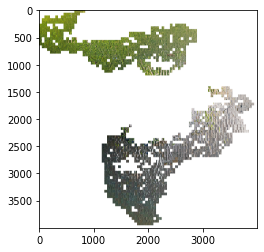

In [64]:
import cv2

small_size = 50
collage = np.ones(shape=(len(y_grid) * small_size, len(x_grid) * small_size, 3), dtype=int) * 255

for i in range(len(x_grid) - 1):
    for j in range(len(y_grid) - 1):
        mask_x = (x_grid[i] <= umap_probs[0]) &  (umap_probs[0] < x_grid[i + 1])
        mask_y = (y_grid[j] <= umap_probs[1]) &  (umap_probs[1] < y_grid[j + 1])
        mask = mask_x * mask_y
        
        if imgs[mask].shape[0] == 0:
            continue

        ri = np.random.choice(np.arange(imgs[mask].shape[0]), 1)[0]
        small_crop = cv2.resize(imgs[mask][ri], dsize=(small_size, small_size), interpolation=cv2.INTER_CUBIC)
        collage[i * small_size: (i + 1) * small_size, j * small_size: (j + 1) * small_size] = small_crop

plt.imshow(collage)

In [85]:
l, r = umap_probs[0].min(), umap_probs[0].max()
d, u = umap_probs[1].min(), umap_probs[1].max()

x_grid = np.linspace(l, r, 50)
y_grid = np.linspace(d, u, 50)

small_size = 50
collage = np.ones(shape=(len(y_grid) * small_size, len(x_grid) * small_size, 3), dtype=int) * 255

for i in range(len(x_grid) - 1):
    for j in range(len(y_grid) - 1):
        mask_x = (x_grid[i] <= umap_probs[0]) &  (umap_probs[0] < x_grid[i + 1])
        mask_y = (y_grid[j] <= umap_probs[1]) &  (umap_probs[1] < y_grid[j + 1])
        mask = mask_x * mask_y
        
        if imgs[mask].shape[0] == 0:
            continue

        ri = np.random.choice(np.arange(imgs[mask].shape[0]), 1)[0]
        small_crop = cv2.resize(imgs[mask][ri], dsize=(small_size, small_size), interpolation=cv2.INTER_CUBIC)
        collage[i * small_size: (i + 1) * small_size, j * small_size: (j + 1) * small_size] = small_crop

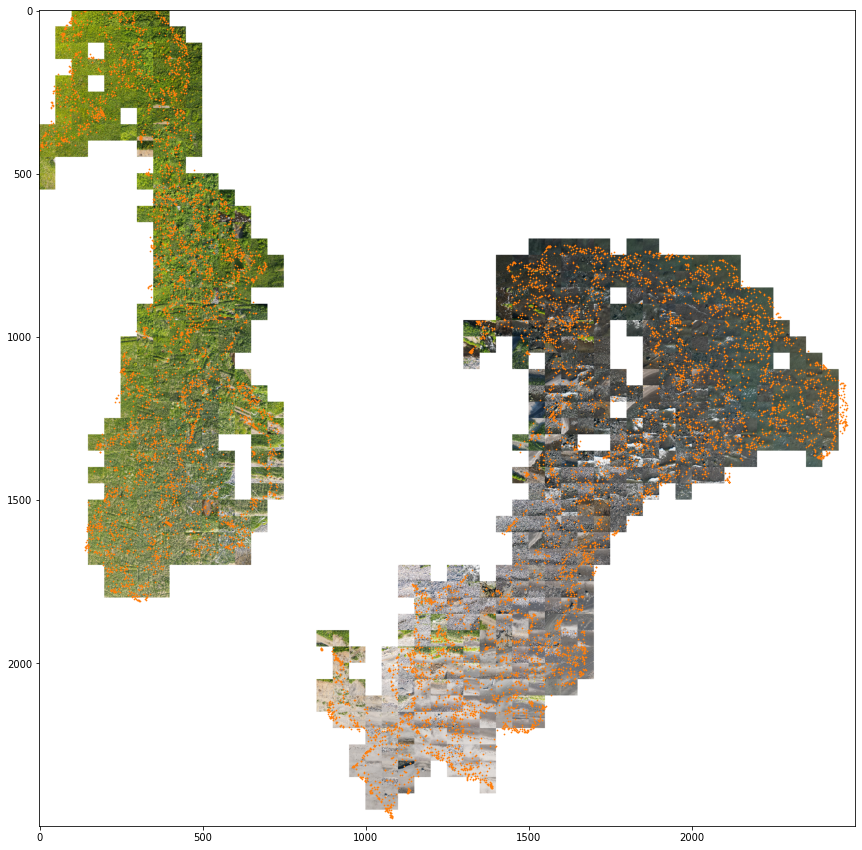

In [86]:
plt.figure(figsize=(15, 15))

plt.scatter(
    (umap_probs[0][mask] - l) / (r - l) * small_size * len(x_grid) - small_size // 2,
    (umap_probs[1][mask] - d) / (u - d) * small_size * len(y_grid) - small_size // 2,
    alpha=1, s=0.5);

plt.scatter(
    (umap_probs[0][~mask] - l) / (r - l) * small_size * len(x_grid) - small_size // 2,
    (umap_probs[1][~mask] - d) / (u - d) * small_size * len(y_grid) - small_size // 2,
    alpha=1, s=0.5);

plt.imshow(collage.transpose(1, 0, 2));